In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext line_profiler
%load_ext memory_profiler
%load_ext Cython

In [3]:
import sys, argparse, logging
import pymssql
import _mssql
from datetime import datetime, time
from decimal import Decimal
import pymongo
from pymongo import MongoClient
from tqdm import tqdm, tnrange, tqdm_notebook
import pandas as pd
from tmqr.settings import *
from tmqrfeed.assetsession import AssetSession
import pickle
import pytz
try:
    from tmqr.settings_local import *
except:
    pass

from tmqrfeed.datafeed import DataFeed

In [4]:
feed = DataFeed()

In [5]:
chain = feed.get_fut_chain("US.CL")
chain_values = chain.get_list(datetime(2011, 1, 1))

In [6]:
FNAN = float('nan')
def resampleer(x):
    if x.name == 'o':
        #print(x)
        if len(x) == 0:
            return FNAN
        else:
            return x[0]
    if x.name == 'h':
        return np.max(x)
    if x.name == 'l':
        return np.min(x)
    if x.name == 'c':
        if len(x) == 0:
            return FNAN
        else:                       
            return x[-1]
    if x.name == 'v':
        return np.sum(x)
    
    return FNAN
    


In [9]:
class DataFrameGetter:
    """
    Implementation of quick Pandas.DataFrame get by label
    Because:
    dataframe['label'].value has overhead due to row-like data alignment inside dataframe
    """
    def __init__(self, df):
        """
        Initiation of fast DF getter
        :param df: Pandas.DataFrame
        """
        # Transpose dataframe data to make it column oriented
        self.data = df.values.T
        self.index = df.index.values

        self.cols = {}
        for i, col_name in enumerate(df.columns):
            self.cols[col_name] = i

    def __getitem__(self, col_name):
        """
        Returns pandas series by label
        :param col_name: column name
        :return: np.ndarray as stored in dataframe[col_name].values
        """
        return self.data[self.cols[col_name]]

In [61]:
%%cython -a

cimport numpy as np
import numpy as np
DTYPE = np.float
ctypedef np.float64_t DTYPE_t
cimport cython
import pandas as pd


@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def compress_daily(dfg):
    """
    Calculate OHLCV based on 1-min data from PreProcessor
    :param dfg: DataFrameGetter instance
    :return:
    """

    cdef DTYPE_t _o, _h, _l, _c,
    cdef DTYPE_t _v = 0.0
    
    npdate_buf = dfg.index.astype('datetime64[D]')
    cdef np.uint64_t[:] npdate = npdate_buf.view(np.uint64)
    
    cdef np.ndarray[DTYPE_t, ndim=2] data = dfg.data

    cdef int io = dfg.cols['o']
    cdef int ih = dfg.cols['h']
    cdef int il = dfg.cols['l']
    cdef int ic = dfg.cols['c']
    cdef int iv = dfg.cols['v']
    cdef int count = data.shape[1]
    cdef int i = 0
    cdef np.uint64_t last_date = -1
    cdef int last_date_idx = -1
    values = []
    values_index = []

    for i in range(count):        
        _v += data[iv, i]
        if i == 0:
            _o = data[io, i]
            _h = data[ih, i]
            _l = data[il, i]
            _c = data[ic, i]
            last_date = npdate[i]
            last_date_idx = i
        else:
            if last_date != npdate[i]:
                values.append(
                    {
                        #'dt': npdate_buf[last_date_idx],
                        'o': _o,
                        'h': _h,
                        'l': _l,
                        'c': _c,
                        'v': _v,
                    }
                )
                values_index.append(npdate_buf[last_date_idx])
                _o = data[io, i]
                _h = data[ih, i]
                _l = data[il, i]
                _c = data[ic, i]
                last_date = npdate[i]
                last_date_idx = i
            else:
                _h = max(_h, data[ih, i])
                _l = min(_l, data[il, i])
                _c = data[ic, i]
                
    # Process last values
    values.append(
                    {
                        #'dt': npdate_buf[last_date_idx],
                        'o': _o,
                        'h': _h,
                        'l': _l,
                        'c': _c,
                        'v': _v,
                    }
                )
    values_index.append(npdate_buf[last_date_idx])
    df_result = pd.DataFrame(values, index=values_index)
    df_result.index.rename('dt', inplace=True)
    return df_result
    

In [33]:
fut = chain.get_contract(datetime(2012, 1, 1))

In [34]:
series = fut.get_series()

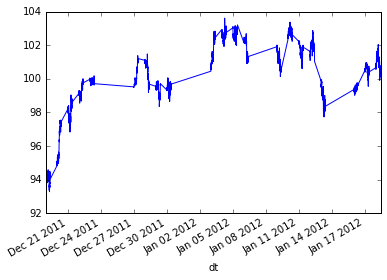

In [35]:
series.c.plot()

In [36]:
 %timeit series.resample('D').apply(resampleer).dropna()

10 loops, best of 3: 19 ms per loop


In [63]:
%timeit compress_daily(DataFrameGetter(series))

1000 loops, best of 3: 1.37 ms per loop


In [62]:
compress_daily(DataFrameGetter(series))

,c,h,l,o,v
dt,,,,,
2011-12-19,94.05,94.63,93.23,93.35,101110.0
2011-12-20,97.47,97.61,94.75,94.77,252255.0
2011-12-21,98.63,99.25,96.80,98.19,394925.0
2011-12-22,99.77,100.05,98.51,99.21,487452.0
2011-12-23,99.71,100.22,99.56,99.98,538922.0
2011-12-27,101.20,101.39,99.49,99.51,598265.0
2011-12-28,99.68,101.50,99.11,101.02,693527.0
2011-12-29,99.71,99.92,98.30,99.55,784923.0
2011-12-30,99.69,100.11,98.61,99.33,855526.0


In [48]:
def get_series():
    df_data = []
    for row in chain_values.iterrows():
        fut_contract, fut_range = row
        try:
            series = fut_contract.get_series()
            df_data.append(series.resample('D').apply(resampleer).dropna())    
        except:
            continue        

In [50]:
def get_series_fast():
    df_data = []
    for row in chain_values.iterrows():
        fut_contract, fut_range = row
        try:
            series = fut_contract.get_series()
            df_data.append(compress_daily(DataFrameGetter(series)))    
        except:
            continue        

In [49]:
%timeit get_series()

1 loop, best of 3: 2.86 s per loop


In [51]:
%timeit get_series_fast()

1 loop, best of 3: 1.72 s per loop


In [8]:
%lprun -f get_series get_series()

In [52]:
%lprun -f get_series_fast get_series_fast()

In [65]:
%lprun -m tmqrfeed.datafeed get_series()